In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import  layers, models
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np


2025-11-11 01:43:10.933941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762807391.054604   65324 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762807391.095974   65324 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762807391.310188   65324 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762807391.310294   65324 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762807391.310301   65324 computation_placer.cc:177] computation placer alr

In [2]:
data_dir = 'dataset'

In [3]:
# class counts
import os
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
counts = {c: sum(1 for f in os.listdir(os.path.join(data_dir, c)) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.gif'))) for c in classes}
print('Number of classes:', len(classes))
for c in classes:
    print(f'{c}: {counts[c]} images')

Number of classes: 5
daisy: 501 images
dandelion: 646 images
roses: 497 images
sunflowers: 495 images
tulips: 607 images


In [4]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# 70% 
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# 30% 
valtest_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Split 30% into 20% val and 10% test 
valtest_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
test_batches = valtest_batches // 3 
test_ds = valtest_ds.take(test_batches)
val_ds  = valtest_ds.skip(test_batches)

val_ds  = valtest_ds.skip(test_batches)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

rescale = tf.keras.layers.Rescaling(1./255)

# Apply augmentation to the training set ONLY, then rescale all datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)

print(f'Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}')
print(f'Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}')    
print(f'Testing batches: {tf.data.experimental.cardinality(test_ds).numpy()}')

Found 2746 files belonging to 5 classes.
Using 1923 files for training.


2025-11-11 01:43:20.998354: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-11-11 01:43:20.998425: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-11 01:43:20.998444: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: afroz
2025-11-11 01:43:20.998457: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: afroz
2025-11-11 01:43:20.998754: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.195.3
2025-11-11 01:43:20.998823: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 570.195.3
2025-11-1

Found 2746 files belonging to 5 classes.
Using 823 files for validation.
Training batches: 61
Validation batches: 18
Testing batches: 8


In [5]:

num_classes = len(classes)

model = models.Sequential([
   
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
   
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
   
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Add this to a new cell
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Add this to a new cell
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2428 - loss: 1.8093 - val_accuracy: 0.4356 - val_loss: 1.3132
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.4547 - loss: 1.3097 - val_accuracy: 0.5203 - val_loss: 1.1532
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.4945 - loss: 1.1956 - val_accuracy: 0.5556 - val_loss: 1.0691
Epoch 4/15
 4/61 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.4902 - loss: 1.1502

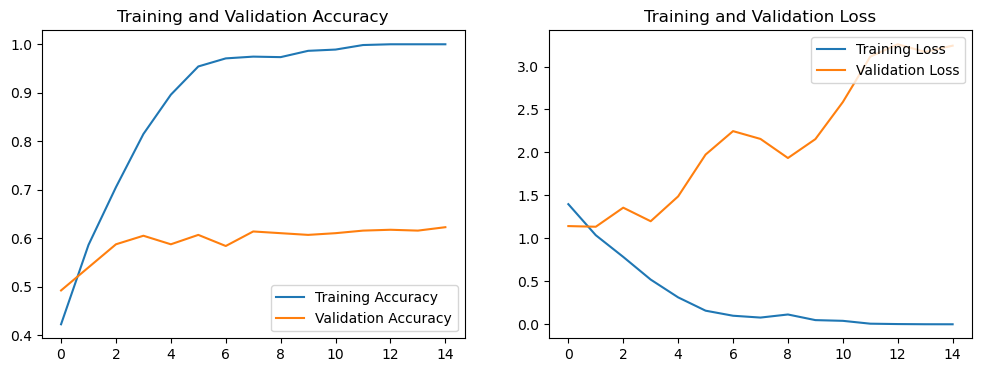

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()